In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

basis = torch.load("checkpoints/mobilenet_v2_l_20/basis_40000.pt")

In [4]:
BASIS_SIZE = 20

def compute_spectrum(basis):
    spectrum = [0] * BASIS_SIZE
    for k in basis.keys():
        for i in range(BASIS_SIZE):
            spectrum[i] += torch.linalg.norm(basis[k][i].flatten()).cpu().numpy() ** 2

    return np.sqrt(np.array(spectrum))

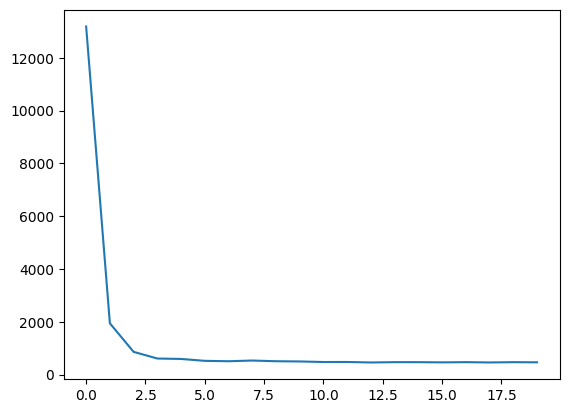

In [11]:
fig, ax = plt.subplots()
spectrum = compute_spectrum(basis)
ax.plot(np.arange(len(spectrum)), spectrum)
plt.show()

In [17]:
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from mobilenetv2 import mobilenet_v2
from tqdm import tqdm
import os

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [19]:
BATCH_SIZE = 32
DATA_DIR = "/home/tejasj/data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
transform = T.Compose(
        [
            T.RandomCrop(32, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
        ]
    )
dataset = CIFAR10(root=DATA_DIR, train=True, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=1,
    drop_last=True,
    pin_memory=True,
)

In [21]:
model = mobilenet_v2(pretrained=True).to(DEVICE)

In [24]:
accuracy = 0

for sample, label in tqdm(dataloader):
    sample = sample.to(DEVICE)
    preds = torch.argmax(model(sample), dim=-1)

    accuracy += (preds == label.to(DEVICE)).sum().cpu().numpy()
    

100%|██████████| 1562/1562 [00:15<00:00, 98.86it/s] 


In [25]:
accuracy /= len(dataset)
accuracy *= 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 95.83%


In [41]:
model = mobilenet_v2(pretrained=True).to(DEVICE)
params = dict(model.named_parameters())

coeffs = {}
for k in basis.keys():
    coeffs[k] = torch.einsum("l...,...->l", basis[k], params[k])

In [42]:
basis = torch.load("checkpoints/mobilenet_v2_l_20/basis_40000.pt")

model = mobilenet_v2(pretrained=True).to(DEVICE)
own_state = model.state_dict()
for k in basis.keys():
    if k not in own_state:
            continue
    projection = torch.einsum("l,l...->...", coeffs[k][:1], basis[k][:1, ...])
    own_state[k].copy_(projection)
model.load_state_dict(own_state)

model.eval()

accuracy = 0

for sample, label in tqdm(dataloader):
    sample = sample.to(DEVICE)
    preds = torch.argmax(model(sample), dim=-1)

    accuracy += (preds == label.to(DEVICE)).sum().cpu().numpy()

accuracy /= len(dataset)
accuracy *= 100
print(f"Accuracy: {accuracy:.2f}%")

100%|██████████| 1562/1562 [00:15<00:00, 99.95it/s] 

Accuracy: 9.99%


In [43]:
basis = torch.load("checkpoints/mobilenet_v2_l_20/basis_40000.pt")

model = mobilenet_v2(pretrained=True).to(DEVICE)
own_state = model.state_dict()
for k in basis.keys():
    if k not in own_state:
            continue
    projection = torch.einsum("l,l...->...", coeffs[k][:20], basis[k][:20, ...])
    own_state[k].copy_(projection)
model.load_state_dict(own_state)

model.eval()

accuracy = 0

for sample, label in tqdm(dataloader):
    sample = sample.to(DEVICE)
    preds = torch.argmax(model(sample), dim=-1)

    accuracy += (preds == label.to(DEVICE)).sum().cpu().numpy()

accuracy /= len(dataset)
accuracy *= 100
print(f"Accuracy: {accuracy:.2f}%")

100%|██████████| 1562/1562 [00:15<00:00, 102.86it/s]

Accuracy: 9.99%
